# Ques 2
 **Audio Reconstruction** - Pick a 5-second audio sample of your liking. Use Random Fourier Features (RFF) and Linear Regression to learn the mapping from time $(t)$ to amplitude $(A)$, where $t$ is the time point, and $A$ is the audio amplitude at that time. Play the reconstructed audio and the original audio to demonstrate reconstruction. Calculate the Root Mean Squared Error (RMSE) and Signal-to-Noise Ratio (SNR) to evaluate the reconstruction.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from sklearn.linear_model import LinearRegression
import torchaudio
from IPython.display import Audio,display

In [2]:
waveform,sample_rate = torchaudio.load("/kaggle/input/audio-file/Taqdeer.mp3")
# Loading the audio
waveform = waveform.mean(0)
# Converting stereo(2 channels) to mono(1 channel) by taking mean of 2 channels
original_audio = waveform[:5*sample_rate]
# Trimming to first 5 seconds

In [3]:
display(Audio(original_audio,rate=sample_rate))# Displaying the original audio

In [4]:
def audio_plot(audio, sr, clr, tl):
    plt.figure(figsize=(15, 4))
    plt.plot(audio, color = clr, alpha = 0.7)
    plt.xticks(np.arange(0, audio.shape[0], sr), np.arange(0, audio.shape[0] / sr, 1))
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.title(tl)
    plt.grid()
    plt.show()

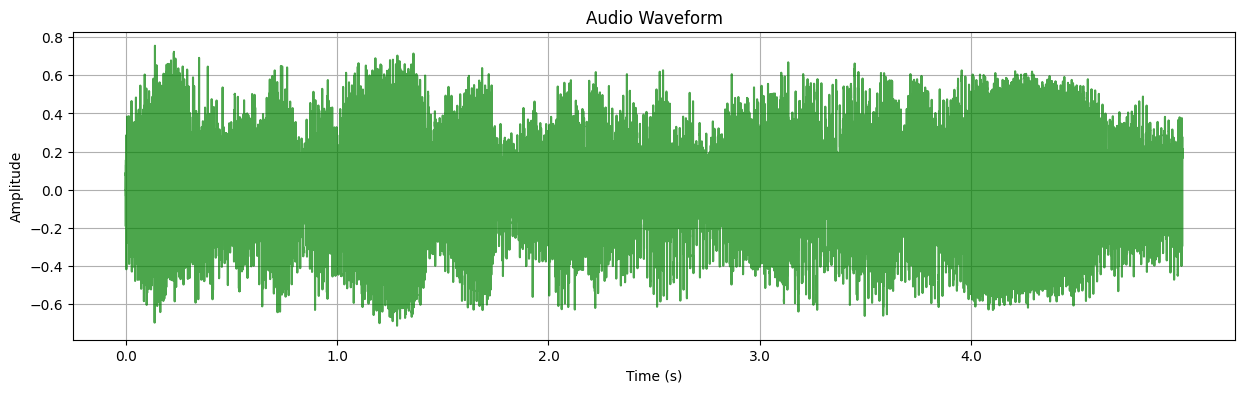

In [5]:
audio_plot(original_audio,sample_rate,"green","Audio Waveform")

In [6]:
X = torch.arange(0, len(original_audio)).unsqueeze(1).float()
X = X / X.max() * 300 - 150 # Converting 0 to 220500 points into [-150,150]
print(X.shape)
print(X)

torch.Size([220500, 1])
tensor([[-150.0000],
        [-149.9986],
        [-149.9973],
        ...,
        [ 149.9973],
        [ 149.9986],
        [ 150.0000]])


### Gaussian Kernel and Random Fourier Features

#### The Gaussian Kernel
$$ K(\textbf{x}, \textbf{x}') = \exp{(-\gamma \lVert \textbf{x} - \textbf{x}' \rVert^2)}, \gamma = \frac{1}{2\sigma^2}$$

#### Since this is infinte dimensional, it can approximated with the **Fourier Transform** of this kernel
$$\gamma(\mathbf{v}) = [\cos({2 \pi \mathbf{B}\mathbf{v}}), \sin({2 \pi \mathbf{B}\mathbf{v}})]^T $$
$$ \mathbf{v} \in \mathbb{R}^{\text{input}} $$
Each entry in $\mathbf{B} \in \mathbb{R}^{m \times \text{input}}$ is sampled from $\mathcal{N}(0, \sigma^2 I)$
$$ \gamma(\mathbf{v}) = [a_1 \cos({2 \pi \mathbf{b}_1^T\mathbf{v}}), a_1 \sin({2 \pi \mathbf{b}_1^T\mathbf{v}}), \cdots, a_m \cos({2 \pi \mathbf{b}_m^T\mathbf{v}}), a_m \sin({2 \pi \mathbf{b}_m^T\mathbf{v}})]^T $$

In [7]:
from sklearn.kernel_approximation import RBFSampler

def create_rff_features(X, num_features, sigma):
    # Setting a random state to the sampler for repoducibility
    rff = RBFSampler(n_components = num_features, gamma = 1 / (2 * sigma**2), random_state = 42)
    X = X.cpu().numpy()
    X = rff.fit_transform(X)
    return torch.tensor(X, dtype = torch.float32)

Signal to Noise-ratio $(\text{SNR})$ is given by the formula : $\text{SNR} = 10 \times \log_{10} \left(\frac{\text{Signal Power}}{\text{Noise Power}}\right)$
* Where, $\text{Signal Power} = \text{mean}(A_{\text{original}}^2)$
* $\text{Noise Power} = \text{mean}((A_{\text{original}} - A_{\text{reconstructed}})^2) = \text{MSE}$

In [8]:
from sklearn.metrics import mean_squared_error
def calculate_metrics(original_signal, reconstructed_signal):
    rmse = np.sqrt(mean_squared_error(original_signal, reconstructed_signal))
    snr = 10 * np.log10(np.mean(original_signal ** 2) / mean_squared_error(original_signal,reconstructed_signal))
    return rmse, snr

In [10]:
num_features = 6000
sigma = 0.02

X_rff = create_rff_features(X, num_features, sigma)
print(X_rff.shape)
print(X_rff)

torch.Size([220500, 6000])
tensor([[-1.6403e-02, -2.3650e-04,  6.5143e-03,  ..., -7.4273e-03,
          6.0155e-03, -1.4536e-02],
        [-1.6664e-02, -6.4900e-05,  5.7587e-03,  ..., -6.0189e-03,
          6.5637e-03, -1.5373e-02],
        [-1.6905e-02,  1.0671e-04,  4.9920e-03,  ..., -4.5863e-03,
          7.1010e-03, -1.6103e-02],
        ...,
        [ 1.7699e-03,  8.4583e-03, -1.6023e-02,  ...,  1.8246e-02,
          1.7088e-02,  4.4655e-03],
        [ 1.1613e-03,  8.6081e-03, -1.6388e-02,  ...,  1.8237e-02,
          1.7282e-02,  3.0703e-03],
        [ 5.4240e-04,  8.7610e-03, -1.6730e-02,  ...,  1.8102e-02,
          1.7462e-02,  1.6030e-03]])


In [11]:
model = LinearRegression()
model.fit(X_rff.numpy(), original_audio)

pred_audio = model.predict(X_rff.numpy())
print(pred_audio.shape)

(220500,)


In [12]:
RMSE,SNR = calculate_metrics(original_audio.numpy(),pred_audio)
print(f"RMSE: {RMSE:.4f}")
print(f"SNR: {SNR:.4f} dB")

RMSE: 0.1041
SNR: 7.5307 dB


In [13]:
L2_norm=np.linalg.norm(pred_audio - original_audio.numpy())
L1_norm=np.linalg.norm((pred_audio - original_audio.numpy()), ord = 1)
print(f"L1 Norm: {L1_norm}")
print(f"L2 Norm: {L2_norm}")

L1 Norm: 18100.62890625
L2 Norm: 48.896575927734375


In [14]:
print("Original Audio:")
display(Audio(original_audio, rate=sample_rate))  

print("Predicted Audio:")
display(Audio(pred_audio, rate=sample_rate))

Original Audio:


Predicted Audio:


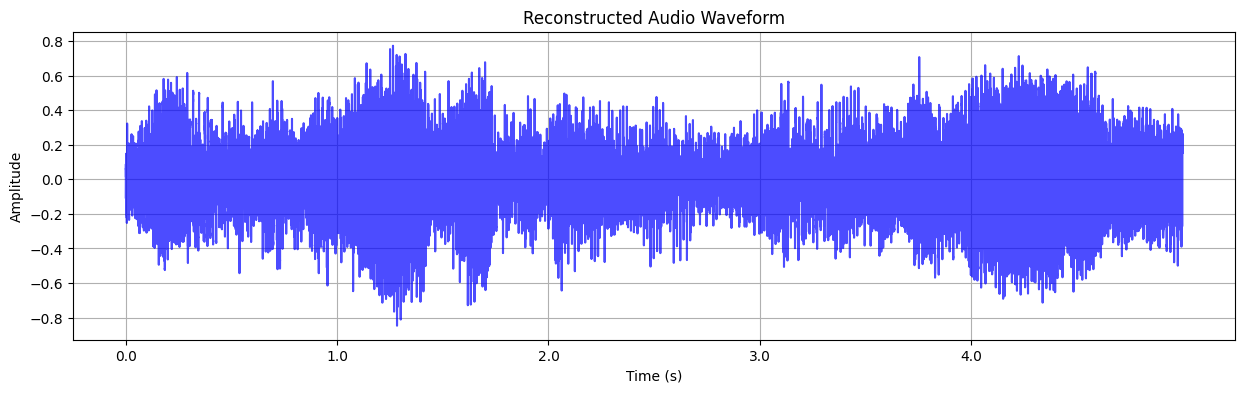

In [15]:
audio_plot(pred_audio, sample_rate, 'blue', 'Reconstructed Audio Waveform')

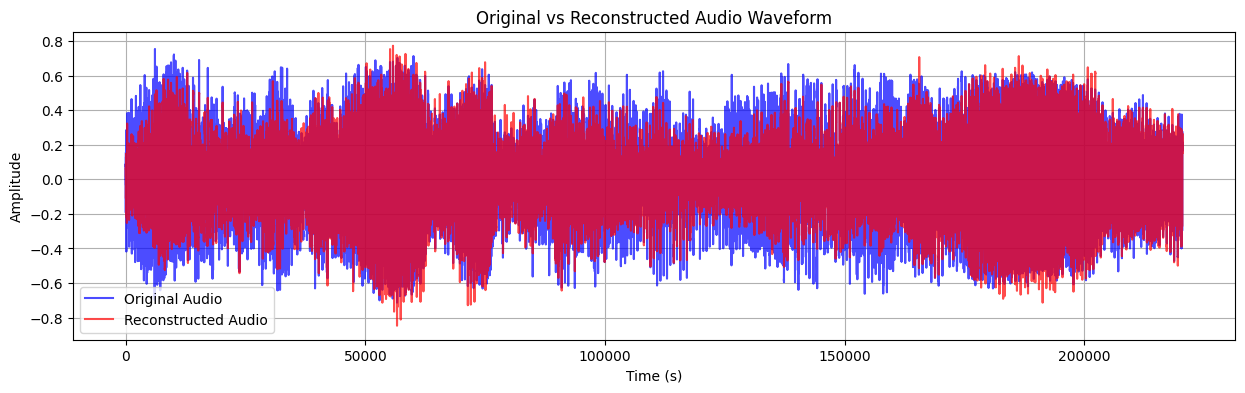

In [16]:
plt.figure(figsize=(15, 4))
plt.plot(original_audio, color = 'blue', alpha = 0.7, label = 'Original Audio')
plt.plot(pred_audio, color = 'red', alpha = 0.7, label = 'Reconstructed Audio')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Original vs Reconstructed Audio Waveform')
plt.grid()
plt.legend()
plt.show()